# Object Detection

安装依赖

In [1]:
!pip install -U pip
!pip install "numpy<2.0" "scipy<1.14" pyyaml pillow matplotlib albumentations opencv-python-headless

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


获取MindYOLO 源码并本地安装

In [2]:
import os, zipfile, shutil, sys, subprocess

CWD = os.path.abspath(".")
REPO_DIR = os.path.join(CWD, "mindyolo_local")
ZIP = os.path.join(CWD, "mindyolo.zip")

if not os.path.isdir(REPO_DIR):
    url = "https://github.com/mindspore-lab/mindyolo/archive/refs/heads/master.zip"
    print("Downloading:", url)
    code = subprocess.call(
        ['bash','-lc', f'curl -L --retry 3 --retry-delay 2 --connect-timeout 10 --max-time 300 -o "{ZIP}" "{url}"']
    )
    assert code == 0 and os.path.exists(ZIP) and os.path.getsize(ZIP) > 100_000, \
        "下载 mindyolo 失败：请更换网络，或从PC下载 mindyolo.zip 后放到当前目录再运行。"

    with zipfile.ZipFile(ZIP) as z:
        z.extractall(CWD)

    subdirs = [d for d in os.listdir(CWD) if d.startswith("mindyolo-") and os.path.isdir(os.path.join(CWD, d))]
    assert subdirs, "解压后未找到 mindyolo-* 目录"
    os.rename(os.path.join(CWD, subdirs[0]), REPO_DIR)
    print("Unzipped to:", REPO_DIR)
else:
    print("Found local MindYOLO at:", REPO_DIR)

subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-deps", "-e", REPO_DIR])
print("MindYOLO ready.")

Found local MindYOLO at: /home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/mindyolo_local
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/mindyolo_local
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: mindyolo
    Found existing installation: mindyolo 0.5.0
    Uninstalling mindyolo-0.5.0:
      Successfully uninstalled mindyolo-0.5.0
  Running setup.py develop for mindyolo


  DEPRECATION: Legacy editable install of mindyolo==0.5.0 from file:///home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/mindyolo_local (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457


MindYOLO ready.


下载权重到当前目录

In [3]:
import os, subprocess

W = os.path.join(CWD, "yolov5n.ckpt")
if not os.path.exists(W):
    print("Downloading yolov5n.ckpt …")
    code = subprocess.call([
        "wget", "-c", "--tries=5", "--timeout=30",
        "https://download.mindspore.cn/toolkits/mindyolo/yolov5/yolov5n_300e_mAP273-9b16bd7b.ckpt",
        "-O", W
    ])
    assert code == 0 and os.path.exists(W), "权重下载失败；请在 PC 下载后放到当前目录。"
else:
    print("Weight exists:", W)

print("权重大小:", os.path.getsize(W)//1024//1024, "MB")

Weight exists: /home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/yolov5n.ckpt
权重大小: 7 MB


检查测试图片

In [4]:
IMG = os.path.join(CWD, "bus.jpg")
assert os.path.isfile(IMG), "缺少 bus.jpg，请先把图片放到当前目录"
print("OK, 使用图片:", IMG, "大小:", os.path.getsize(IMG)//1024, "KB")

OK, 使用图片: /home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/bus.jpg 大小: 134 KB


推理并显示目标识别结果

RUN: python "/home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/mindyolo_local/demo/predict.py" --config "/home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/mindyolo_local/configs/yolov5/yolov5n.yaml" --weight "/home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/yolov5n.ckpt" --image_path "/home/HwHiAiUser/orange-pi-mindspore/Online/community/ObjectDetection/bus.jpg" --conf_thres 0.25 --iou_thres 0.45 --img_size 640 --save_result False
[WARNING] DEVICE(12681,e7ffd2b2c020,python):2025-08-31-17:09:48.526.749 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclprofGetSupportedFeaturesV2 failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libmsprofiler.so: undefined symbol: aclprofGetSupportedFeaturesV2
[WARNING] DEVICE(12681,e7ffd2b2c020,python):2025-08-31-17:09:48.526.879 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclrtEventGetTimestamp failed, result = /

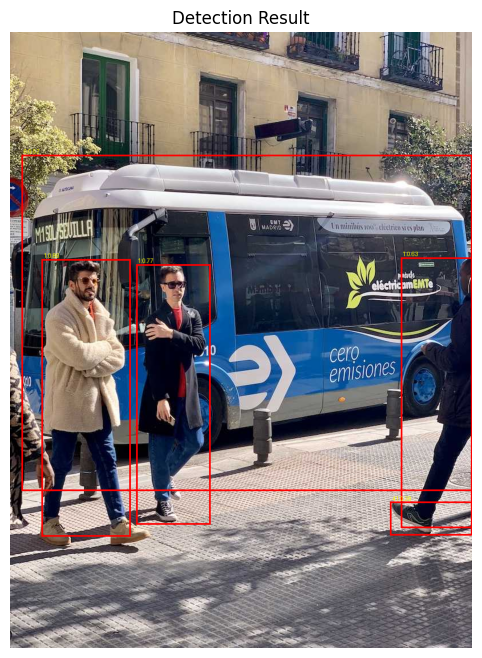

In [5]:
import os, re, ast, subprocess, shlex
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

repo = REPO_DIR
cfg  = os.path.join(repo, "configs/yolov5/yolov5n.yaml")

# 运行推理
cmd_try = (
    f'python "{os.path.join(repo, "demo/predict.py")}" '
    f'--config "{cfg}" --weight "{W}" --image_path "{IMG}" '
    f'--conf_thres 0.25 --iou_thres 0.45 --img_size 640 '
    f'--save_result False'
)
print("RUN:", cmd_try)
proc = subprocess.run(shlex.split(cmd_try), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
log = proc.stdout
print(log)

# 如果报 unrecognized arguments，则回退不带 --save_result
if "unrecognized arguments: --save_result" in log:
    print("\nRe-running without --save_result …\n")
    cmd_alt = (
        f'python "{os.path.join(repo, "demo/predict.py")}" '
        f'--config "{cfg}" --weight "{W}" --image_path "{IMG}" '
        f'--conf_thres 0.25 --iou_thres 0.45 --img_size 640'
    )
    proc = subprocess.run(shlex.split(cmd_alt), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    log = proc.stdout
    print(log)

# 解析日志中的预测结果
m = re.search(r"Predict result is:\s*(\{.*\})", log)
assert m, "没有在日志中找到预测结果"
pred = ast.literal_eval(m.group(1))

# 绘制检测框
img = Image.open(IMG).convert("RGB")
draw = ImageDraw.Draw(img)
for (x, y, w, h), cls, sc in zip(pred["bbox"], pred["category_id"], pred["score"]):
    x1, y1, x2, y2 = x, y, x + w, y + h
    draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0), width=3)
    txt = f"{cls}:{sc:.2f}"
    draw.text((x1+3, y1-12), txt, fill=(255, 255, 0))

plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis("off")
plt.title("Detection Result")
plt.show()